# Real NVP

In [1]:
# Import required packages
!pip install git+https://github.com/telegraphroad/NNF.git
import torch
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm

  Cloning https://github.com/telegraphroad/NNF.git to /tmp/pip-req-build-rb7xko9y
  Running command git clone --filter=blob:none --quiet https://github.com/telegraphroad/NNF.git /tmp/pip-req-build-rb7xko9y
  Resolved https://github.com/telegraphroad/NNF.git to commit 7b4d90f08e945d40243880a2f9b0796e26d79c00
  Preparing metadata (setup.py) ... done


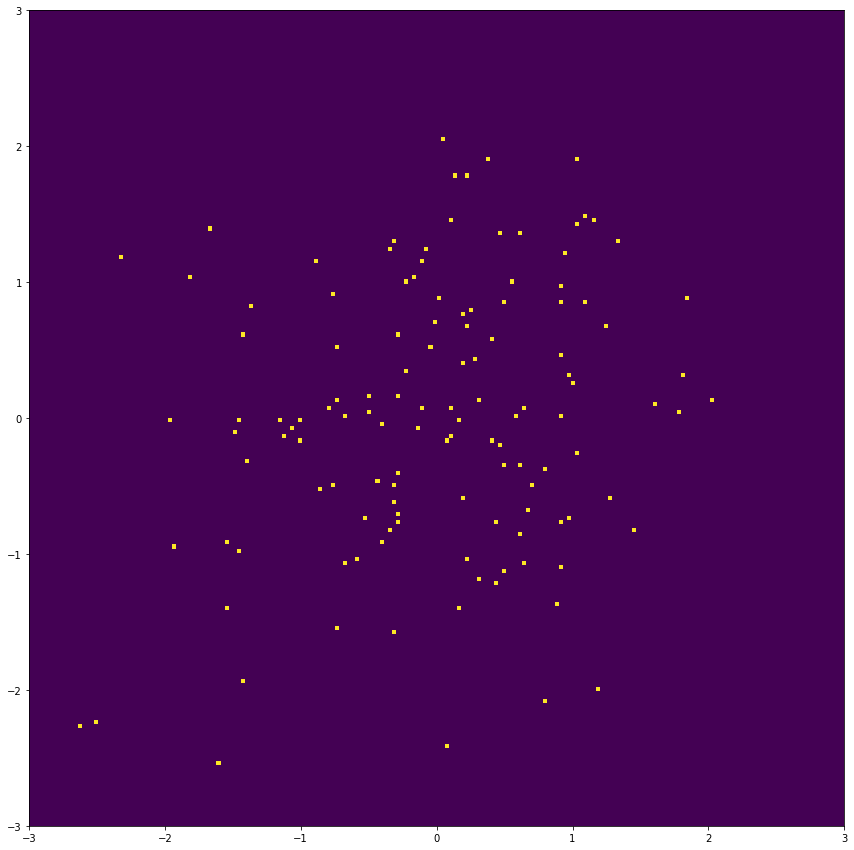

In [2]:
# Set up model

# Define flows
K = 64
torch.manual_seed(0)

latent_size = 2
b = torch.Tensor([1 if i % 2 == 0 else 0 for i in range(latent_size)])
flows = []
for i in range(K):
    s = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    t = nf.nets.MLP([latent_size, 2 * latent_size, latent_size], init_zeros=True)
    if i % 2 == 0:
        flows += [nf.flows.MaskedAffineFlow(b, t, s)]
    else:
        flows += [nf.flows.MaskedAffineFlow(1 - b, t, s)]
    flows += [nf.flows.ActNorm(latent_size)]

# Set prior and q0
prior = nf.distributions.TwoModes(2, 0.1)
q0 = nf.distributions.DiagGaussian(2)

# Construct flow model
nfm = nf.NormalizingFlow(q0=q0, flows=flows, p=prior)

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
nfm = nfm.to(device)
nfm = nfm.double()

# Initialize ActNorm
z, _ = nfm.sample(num_samples=2 ** 7)
z_np = z.to('cpu').data.numpy()
plt.figure(figsize=(15, 15))
plt.hist2d(z_np[:, 0].flatten(), z_np[:, 1].flatten(), (200, 200), range=[[-3, 3], [-3, 3]])
plt.gca().set_aspect('equal', 'box')
plt.show()

/home/samiri/anaconda3/envs/flows/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


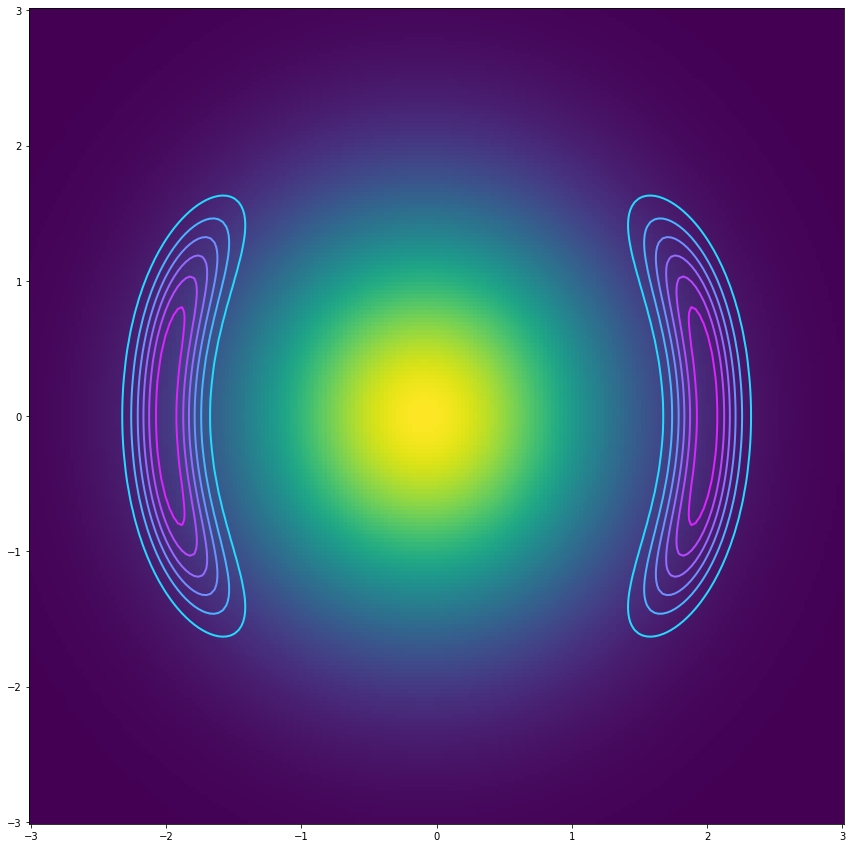

In [3]:
# Plot prior distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.double().to(device)
log_prob = prior.log_prob(zz).to('cpu').view(*xx.shape)
prob_prior = torch.exp(log_prob)

# Plot initial posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()

In [4]:
# Train model
max_iter = 20000
num_samples = 2 * 10
anneal_iter = 10000
annealing = True
show_iter = 1000


loss_hist = np.array([])

optimizer = torch.optim.Adam(nfm.parameters(), lr=1e-4, weight_decay=1e-6)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    if annealing:
        loss = nfm.reverse_kld(num_samples, beta=np.min([1., 0.001 + it / anneal_iter]))
    else:
        loss = nfm.reverse_alpha_div(num_samples, dreg=True, alpha=1)
    
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot learned posterior
    if (it + 1) % show_iter == 0:
        log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
        prob = torch.exp(log_prob)
        prob[torch.isnan(prob)] = 0

        plt.figure(figsize=(15, 15))
        plt.pcolormesh(xx, yy, prob.data.numpy())
        plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.show()

plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

  1%|▍                                                           | 129/20000 [00:17<45:12,  7.33it/s]


KeyboardInterrupt: 

In [ ]:
# Plot learned posterior distribution
log_prob = nfm.log_prob(zz).to('cpu').view(*xx.shape)
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

plt.figure(figsize=(15, 15))
plt.pcolormesh(xx, yy, prob.data.numpy())
plt.contour(xx, yy, prob_prior.data.numpy(), cmap=plt.get_cmap('cool'), linewidths=2)
plt.gca().set_aspect('equal', 'box')
plt.show()